## Module 7: Machine Learning with `scikit-learn`

Start by importing already-familiar packages (discussed in previous modules)

In [1]:
import itertools as it
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

Scikit-learn is a package for 'shallow' machine-learning models - that is, everything that is not deep learning. It offers models for both supervised and unsupervised learning, as well as auxillary tools for arraning and pre-processing the data before learning, and for evaluating results after. 

Here is how it works. Once you pick your model of choice, you intialize a model object with the right hyper-parameters. You then train it on your pre-processed data, which sets the learned parameters of the model object. You can now use the model object for validation, cross-validation, and for obtaining predictions for new data.

In this module we will go over a few examples, but you should check out the [Official scikit-learn documentation](http://scikit-learn.org/stable/documentation.html) for all available models.

Also note that this module is not intended to teach you how to design and implement a machine learning project, just how to implement it in python.

# Classification (supervised learning)

**Example data set.** We will try to separate rocks from mines using this [data set](https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks). These data use sonar readings from different angles on different objects. The first 534 columns are different measurements, the last is a label - "R" for rocks and "M" for mines. 

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data', header=None, prefix='X')
# df = pd.read_csv('https://raw.github.com/pandas-dev/''pandas/master/pandas/tests/io/data/csv/iris.csv')
df.shape

(208, 61)

The last column are the labels. It is useful to change its type to category, which is the type Pandas use for variables that can only take a fixed set of values.

In [3]:
df.rename(columns={'X60':'Label'},inplace=True)
df.Label = df.Label.astype('category')
df.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X51,X52,X53,X54,X55,X56,X57,X58,X59,Label
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


### Exploratory look at the data


Always a good idea to strat with making some basic plots to get a general idea of the data. 

- Is the separation between mines and rocks obvious?
- How correlated are the variables?
- Do we need to standardize?
- Are there outliers?

### Is there a clear separation between rocks and mines?

First, we can plot the data in two formats that are often used to search for clustering in the data. 
If you want to know more about them, here are the wikipedia articles for [Andrew plots](https://en.wikipedia.org/wiki/Andrews_plot) and for [Parallel coordinates](https://en.wikipedia.org/wiki/Parallel_coordinates)

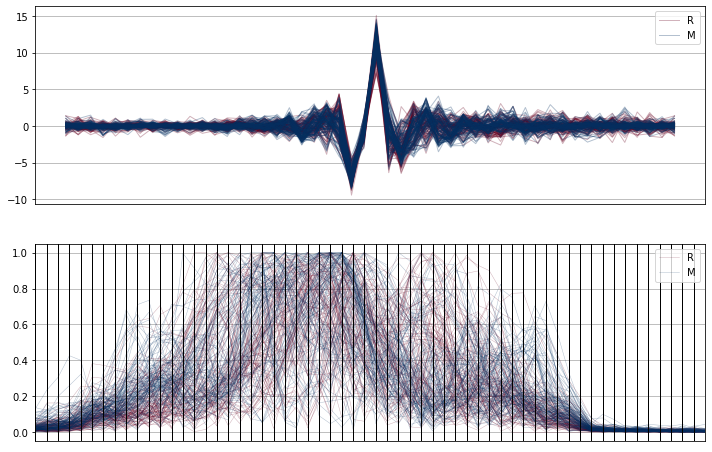

In [4]:
fig, axes = plt.subplots(2,1,figsize=(12,8))
pd.plotting.andrews_curves(df, 'Label', samples=50, linewidth=1.0,colormap='RdBu', ax=axes[0],alpha=0.3)
axes[0].set_xticks([])
pd.plotting.parallel_coordinates(df, 'Label', linewidth=0.5,colormap='RdBu', ax=axes[1],alpha=0.3)
axes[1].set_xticks([])
axes[1].margins(0.05)

### Visualize separation, clustering and outliers with MDS

The scikit-learn package offes several algorithms for presenting multidimensional data on lower dimensional manifolds. TSNE is a popular choice. 

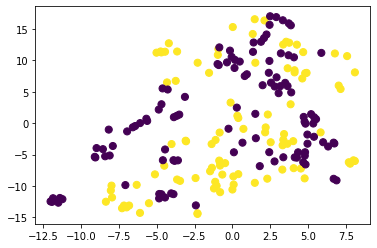

In [5]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(df.iloc[:, :-1])
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=df.Label.cat.codes, s=50);

It doesn't seem like there is an obvious spration between the two classes, but they are also not completely mixed. This is exactly the gray area where ML approaches could be useful. 

### How correlated are the different features?

When our data has a large number of features (or attributes) we will suffer the so-called 'curse of dimensionality'. It is therefore good idea to see if we actually need all these features - if some features are highly correlated, we could remove some of them.

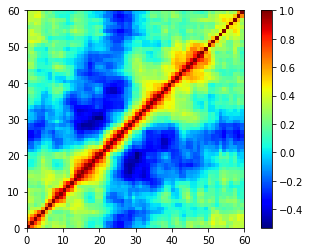

In [6]:
heatmap = plt.pcolor(df.corr(), cmap='jet')
plt.colorbar(heatmap)
plt.gca().set_aspect('equal')

### Are the variables on the same scale? Are there outliers?

<AxesSubplot:>

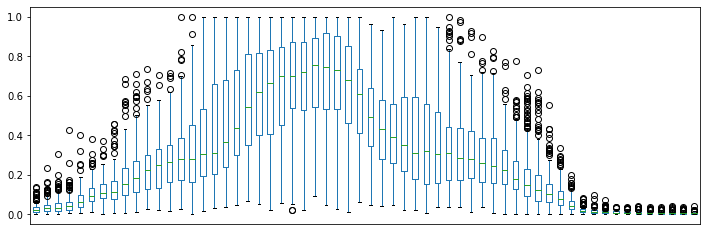

In [7]:
df.plot.box(figsize=(12,4), xticks=[])

### Preprocessing

First, for convinience, let's separate the attributes from the labels. The `drop` method allows us to remove columns (or rows) from a dataframe by name, or we could use boolean indexing to remove columns by criteria (see the Pandas module for more on this).

In [8]:
data, labels = df.drop('Label',axis=1), df['Label']
data.head(3)

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078


The Box plot suggests that different attibutes are on differnet scales. We should therefore standardize the data. scikit-learn provides some convinient tools for that. StandardScalar is standardizing each column by removing the mean and dividing by the standard deviation. 

In [9]:
from sklearn.preprocessing import StandardScaler, RobustScaler

data_scaled = pd.DataFrame(StandardScaler().fit_transform(data), columns=data.columns)
data_scaled.head(3)

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59
0,-0.399551,-0.040648,-0.026926,-0.715105,0.364456,-0.101253,0.521638,0.297843,1.125272,0.021186,...,0.595283,-1.115432,-0.597604,0.680897,-0.295646,1.481635,1.763784,0.069870,0.171678,-0.658947
1,0.703538,0.421630,1.055618,0.323330,0.777676,2.607217,1.522625,2.510982,1.318325,0.588706,...,-0.297902,-0.522349,-0.256857,-0.843151,0.015503,1.901046,1.070732,-0.472406,-0.444554,-0.419852
2,-0.129229,0.601067,1.723404,1.172176,0.400545,2.093337,1.968770,2.852370,3.232767,3.066105,...,-1.065875,1.017585,0.836373,-0.197833,1.231812,2.827246,4.120162,1.309360,0.252761,0.257582


If there are gross outliers, we can use a more robust routine

In [10]:
data_robust = pd.DataFrame(RobustScaler().fit_transform(data), columns=data.columns)
data_robust.head(3)

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59
0,-0.126126,0.200000,0.217949,-0.581931,0.528726,0.096125,0.642271,0.538267,1.163123,0.182309,...,0.750000,-0.920635,-0.310433,0.723288,-0.037736,1.595142,1.791822,0.385185,0.390977,-0.387097
1,1.013514,0.682540,1.282051,0.619315,0.896746,2.476155,1.486320,2.646482,1.330279,0.665714,...,-0.112903,-0.317460,-0.066158,-0.493151,0.238994,1.983806,1.197026,-0.133333,-0.180451,-0.165899
2,0.153153,0.869841,1.938462,1.601246,0.560868,2.024590,1.862517,2.971685,2.987903,2.775925,...,-0.854839,1.248677,0.717557,0.021918,1.320755,2.842105,3.814126,1.570370,0.466165,0.460829


### Dimension reduction

Perhaps the simplest and best-known approach to dimensional reduction and/or feature extraction is the linear Principle Component Analysis (PCA)

In [11]:
from sklearn.decomposition import PCA

In [12]:
pca = PCA()
data_scaled_pca = pd.DataFrame(pca.fit_transform(data_scaled), columns=data.columns)

In and of itself, PCA does not change the dimensionality of the date

In [13]:
print (data.shape , data_scaled.shape)

(208, 60) (208, 60)


But we can check how much of the variance is explained by the ordered principle components

,explaining,explained
0,0.203466,0.203466
1,0.188972,0.392438
2,0.085500,0.477938
3,0.056792,0.534730
4,0.050071,0.584800
5,0.040650,0.625450
6,0.032790,0.658240
7,0.030465,0.688705
8,0.025660,0.714364
9,0.024911,0.739275


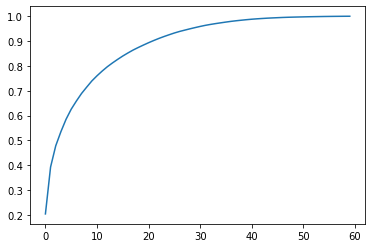

In [14]:
v = pca.explained_variance_ratio_
vc = v.cumsum()
plt.plot(vc)
pd.DataFrame({'explaining':v,'explained': vc}).head(10)

We can ask, for example, how many components are needed to explain 95% of total variance, and then keep only these components for further analysis. This will help us fight the 'curse of dimensionality'

In [15]:
n_comps = 1 + np.argmax(vc > 0.95) 
data_scaled_pca = data_scaled_pca.iloc[:, :n_comps]
data_scaled_pca.shape

(208, 30)

### Classification Models

The first step in any ML workflow is to split the data to a training set and a test set. 

In [16]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = \
  train_test_split(data_scaled_pca, labels, test_size=0.33, random_state=42)    # random_state makes sure that the split is 
                                                                                # "random", but will be exactly the same                                                                       # every time we run this block

#### Approach 1: Logistic regression

In [17]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test) # accuracy

0.7971014492753623

#### Approach 2: Support Vector Classifier and Grid Search

Next, we can try to build a Suppor Vector Classifier. Setting up an SVM requires setting up several hyper-parameters, such as the Regularization parameter C, the choice of a kernel, the kernel parameters, etc.

One thing scikit-learn allows us to do is to set different possible values for each parameter, and train SVMs on every possible combination. This is called a grid search in the space of hyper-parameters. 

In [18]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [19]:
# here are the possible parameter choices. Note that for different kernels we specify different choices.

parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
               'C': [1, 10, 100, 1000]},
               {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

In [20]:
clf = GridSearchCV(SVC(C=1), parameters, cv=5, scoring='accuracy', n_jobs=-1)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(C=1), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             scoring='accuracy')

When its done, the grid search identified the best hyper-parameters to use, and will use the best SVM to classify new data.

In [21]:
clf.best_params_

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

In [22]:
clf.best_score_

0.7693121693121693

The trained GridSearch object now behaves like any other classification model, and you could use it like you would use any trained model.

In [23]:
clf.score(X_test, y_test)

0.8260869565217391

For better understanding of how well your classifier performs on your test set, scikit-learn provides reporting tools.

In [24]:
from sklearn.metrics import classification_report

In [25]:
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           M       0.82      0.87      0.85        38
           R       0.83      0.77      0.80        31

    accuracy                           0.83        69
   macro avg       0.83      0.82      0.82        69
weighted avg       0.83      0.83      0.83        69



#### Approach 3: Random Forests Classifier

Just for good measure, let's also try a Random Forest classifier. Again, we will do a grid search to choose the hyper parameters.

In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
X_train, X_test, y_train, y_test = \
  train_test_split(data_scaled, labels, test_size=0.33, random_state=42)

In [28]:
parameters = [{'n_estimators': list(range(25, 201, 25)),
               'max_features': list(range(2, 15, 2))}]
clf = GridSearchCV(RandomForestClassifier(), parameters, 
                   cv=5, scoring='accuracy', n_jobs=-1)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'max_features': [2, 4, 6, 8, 10, 12, 14],
                          'n_estimators': [25, 50, 75, 100, 125, 150, 175,
                                           200]}],
             scoring='accuracy')

In [29]:
clf.best_params_

{'max_features': 10, 'n_estimators': 75}

In [30]:
clf.score(X_test, y_test)

0.7971014492753623

If we want to understand how the machine makes its classification decision, we can ask which features are important in this classification. 

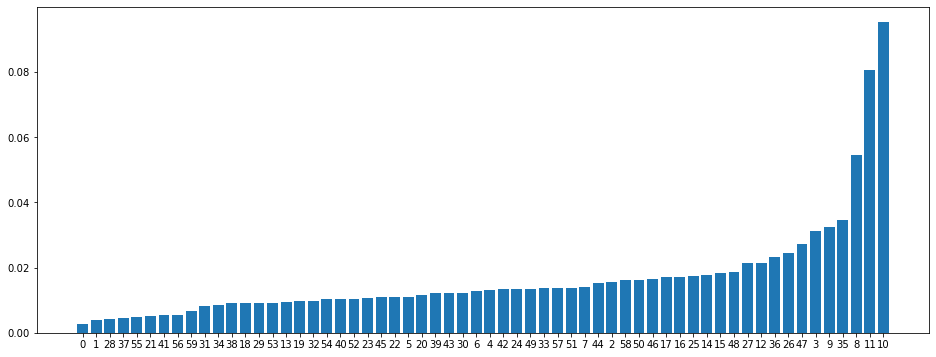

In [31]:
imp = clf.best_estimator_.feature_importances_
idx = np.argsort(imp)

plt.figure(figsize=(16, 6))
plt.bar(range(len(imp)), imp[idx])
_=plt.xticks(np.arange(len(imp)), idx)

### ML Pipeline

In many cases we want to group together all the steps in our ML pipeline. The pipeline can then be used as any other classifier. This will allow, for example, grid search over parameters from different parts of the workflow, efficient cross-validation, and more. Here is how we could group the steps we described above into a pipeline object.

In [32]:
from sklearn.pipeline import Pipeline

In [33]:
X_train, X_test, y_train, y_test = \
  train_test_split(data, labels, test_size=0.33, random_state=42)

In [34]:
scaler = StandardScaler()
pca = PCA()
clf = LogisticRegression()

pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('clf', clf)])
n_components = [ 20, 30, 40, 50, 60]
Cs = np.logspace(-4, 4, 5)

estimator = GridSearchCV(pipe,{'pca__n_components':n_components,'clf__C':Cs}, n_jobs=-1)
estimator.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'clf__C': array([1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04]),
                         'pca__n_components': [20, 30, 40, 50, 60]})

In [35]:
estimator.best_estimator_.named_steps['pca'].n_components
estimator.score(X_test, y_test)

0.782608695652174

In [36]:
y_true, y_pred = y_test, estimator.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           M       0.79      0.82      0.81        38
           R       0.77      0.74      0.75        31

    accuracy                           0.78        69
   macro avg       0.78      0.78      0.78        69
weighted avg       0.78      0.78      0.78        69



# Clustering (unsupervised learning)

Of the different unsupervised learning approaches, clustering is probably the best-known and most frequently used. Since clustering is an ill-defined problem, many algorithms and heuristic will perform differently on different data sets. The Scikit-learn offers many such algorithms for you to choose from. Let's start with two that require that you define the expected number of clusters. 

For easy visualization we'll demonstrate using synthetic two-dimensional data.

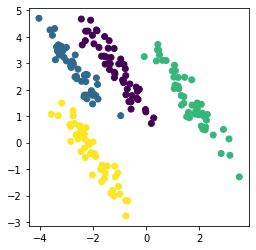

In [37]:
from sklearn import datasets
n_samples = 200
data, labels = datasets.make_blobs(n_samples=n_samples, centers=4, random_state=3)
data = np.dot(data, [[0.6, -0.6], [-0.4, 0.8]])

plt.scatter(data[:, 0], data[:, 1],c=labels)
plt.gca().set_aspect('equal')

First try the famous k-means algoruthm. In the plot we will mark the  centers of the inferred clusters. 

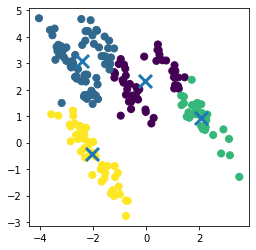

In [38]:
from sklearn.cluster import KMeans

kmeans = KMeans(init="k-means++", n_clusters=4, n_init=4)
kmeans.fit(data)

plt.scatter(data[:, 0], data[:, 1], c=kmeans.labels_, s=50);

centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,zorder=10)
plt.gca().set_aspect('equal')

k-means assumes that the clusters are compact, which is clearly not the case here, so its failure is understandable. Things should be better with Spectral Clutering.

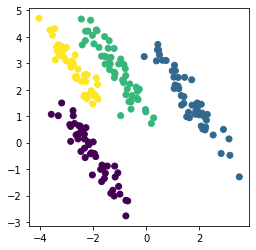

In [39]:
from sklearn.cluster import SpectralClustering

spc = SpectralClustering(n_clusters=4,assign_labels="discretize",random_state=3, 
        affinity="nearest_neighbors")
spc.fit(data)

plt.scatter(data[:, 0], data[:, 1], c=spc.labels_);
plt.gca().set_aspect('equal')

Since our data has label (which we haven't used for clustering!) we can evaluate our clustering performance. We do this here by calculating a confusion matrix, and then displaying it with a nice visualization method.

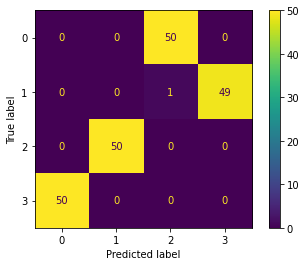

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion_matrix(labels, spc.labels_)).plot()

The other type of clustering approach is agglomerative clustering, which builds clusters by iteratively joining pairs of points or smaller clusters together. This hierarchy can then be visualized.

While Scikit-learn provides models for agglomerative clustering, a better interface is provided by the scipy package.  

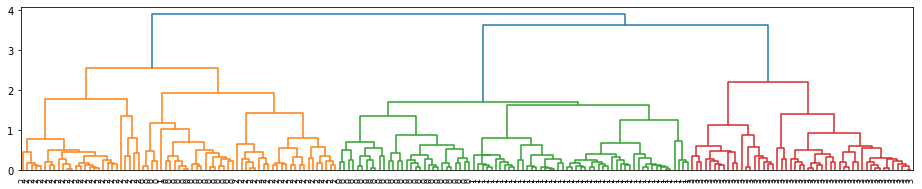

In [41]:
from scipy.cluster.hierarchy import dendrogram, linkage


Z = linkage(data,'average')
plt.figure(figsize=(16,3))
dn = dendrogram(Z,leaf_font_size=8,labels=labels)

